**A note of docking PFAS into protein systems using both AutoDock Vina and AlphaFold 3**

Xiping Gong (xipinggong@uga.edu) from the [Jack Huang's Lab](https://site.caes.uga.edu/huanglab/)


# Introduction

This note is to show one of my projects on how I did the molecular docking by using the conventional AutoDock Vina or AlphaFold 3 programs. In this project, I looked at the PFAS docking into the protein systems sourced from the PDB database. 


# A general procedure

## Collecting a list of PDBID files

### Get the component.cif file from the PDB

This file can be downloaded from the following link:
```bash
https://files.wwpdb.org/pub/pdb/data/monomers/components.cif
```
This file includes all ligand systems in the PDB database.
We can extract the interested ligands from this file, like the F-containing ligands and PFAS, to directly obtain the important ligand info.

```bash
# Download this responsitory to the local.
$ git clone https://github.com/XipingGong/pfas_docking.git

# Download the input data file, and I assume that this responsitory was downloaded into the following test folder
$ cd /home/xipinggong/work/pfas_docking/test # go to this test directory
$ wget https://files.wwpdb.org/pub/pdb/data/monomers/components.cif # download this cif file
```

### Get the fluorine-containing ligand ID and its info from the component.cif

```bash
$ ls ../scripts # check out whether we can reach the "scripts" folder
$ python ../scripts/get_ligand_id_from_ccdcif.py -h # check the usage of a python script: get_ligand_id_from_ccdcif.py
# Note: every python scipt has this function to check out the usage.

$ python ../scripts/get_ligand_id_from_ccdcif.py components.cif 1 | tee ligand_id_from_ccdcif.log # the output will be written into the log file.
$ head -3 ligand_id_from_ccdcif.log # as of 2/14/2025
>> # Ligand IDs - Found 6908 ligands with at least 1 fluorine atoms:
>> Ligand ID: W1Z ; SMILES: OC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F ; Fluorine Count: 23 ;
>> Ligand ID: W10 ; SMILES: OC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F;  Fluorine Count: 19 ;
```

### Search PDBIDs for each ligand ID

```bash
$ python ../scripts/get_pdbid_by_ligand_id.py 8PF # 8PF is the name of a ligand ID.
>> Ligand ID: 8PF ; PDBID: 5JID 6GON 6GOO 7AAI 7FEK 8U57 ;

# To process a batch of ligand IDs, a bash script (batch_processing.sh) can be used
$ awk '/^#/ {print} /Ligand ID:/ {print $3}' ligand_id_from_ccdcif.log  > tmp.log # store the input arguments
$ bash ../scripts/batch_processing.sh ../scripts/get_pdbid_by_ligand_id.py tmp.log > pdbid_by_ligand_id.log # computation-intensive, ~2 hours

# Save the results into a final log file
$ grep 'Ligand' pdbid_by_ligand_id.log > tmp.log
$ paste ligand_id_from_ccdcif.log tmp.log > ccdcif_info.log
# Now, we can collect all PDB IDs that include the fluorine-containing ligand IDs.
```

### Identify PFAS ligands from the obtained data file: ccdcif_info.log

```bash
# Check out the following Python script to filter out the PFAS with a defined pattern
$ python ../scripts/filter_ligands_by_smile.py -h

# R-CF2-CF(R')(R") where R, R', R" ≠ H; US EPA OPPT definition: '[CX4]([!#1])(F)(F)-[CX4](F)([!#1])([!#1])'
# CF3 or CF2 pattern with no H/Cl/Br/I substituents; OECD definition: '[$([#6X4]([!#1;!Cl;!Br;!I])(F)(F)(F)),$([#6X4](F)(F)([!#1;!Cl;!Br;!I])([!#1;!Cl;!Br;!I]))]'
$ python ../scripts/filter_ligands_by_smile.py ccdcif_info.log '[$([#6X4]([!#1;!Cl;!Br;!I])(F)(F)(F)),$([#6X4](F)(F)([!#1;!Cl;!Br;!I])([!#1;!Cl;!Br;!I]))]' | tee ligand_pdb_oecd.log 

# Clean ligand & pdbid log file
$ python ../scripts/clean_ligand_pdb_log.py ligand_pdb_oecd.log | tee pdb_ligand_oecd_cleaned.log
>> 5B2W --ligand_id W1Z
>> 5B2Y --ligand_id W10
>> 7FEU --ligand_id 4I6
>> 4E99 --ligand_id P8S
# In total, it has 2805 pdbids.

# You want to see what they look like? Please see the section "Visualization of Ligands" in the Appendix.
```

### Download the PDB files for PFAS ligands

```bash
# Use a Python script to download the pdb file
$ python ../scripts/download_pdb.py 5B2W --ligand_id W1Z # W1Z is ligand_id and 5B2W is PDBID.
>> PDB file ./5B2W_W1Z.pdb downloaded successfully.

# Batch processing
$ bash ../scripts/batch_processing.sh ../scripts/download_pdb.py pdb_ligand_oecd_cleaned.log --output_dir pdbs | tee download_pdb_oecd.log 
# all pdb files will go to the folder named as "pdbs"
# Note: it could fail to download some of PDB files, please check out the log file.
# 2,765 pdb files have been downloaded and 40 pdbid failed.

```

### Filter PDB files for molecular docking

```bash
# Save the pdb files into a log file
$ ls -ltr pdbs/*.pdb
>> -rw-r--r-- 1 xg69107 qhlab  663275 Feb 13 12:42 pdbs/5B2W_W1Z.pdb
>> ...
$ ls -ltr pdbs/*.pdb | awk '{split($NF, arr, "_"); sub(".pdb", "", arr[2]); print $NF, "--ligand_id", arr[2]}' | tee pdbs_oecd.log
>> pdbs/5B2W_W1Z.pdb --ligand_id W1Z
>> pdbs/5B2Y_W10.pdb --ligand_id W10
>> pdbs/7FEU_4I6.pdb --ligand_id 4I6

# Check the pdb files and save the basic info (like mutliple proteins or ligands, # residues) into a log file
$ bash ../scripts/batch_processing.sh ../scripts/check_pdb.py pdbs_oecd.log > check_pdb_oecd.log

# Filter out the pdb files (1-protein & 1-ligand_id) to run the molecular docking
$ python ../scripts/extract_check_pdb_log.py check_pdb_oecd.log | grep -E "type_11|Type|===" > pdbs_oecd_for_docking.log 
>> PDB File  Total Atoms  Total Residues  Missing Atoms  Multiple Ligands   Multiple Protein Chains   PDB Type
>> ===========================================================================================================
>> pdbs/7FEU_4I6.pdb     1307       354      True       False         False    type_11
>> pdbs/5TGY_7BU.pdb     1849       110      False      False         False    type_11
>> pdbs/3RZ7_RZ7.pdb     2376       565      True       False         False    type_11
# 1,086 pdb files identified. These pdb files have been saved into a log file: pdbs_oecd_for_docking.log
```

### Get the released date of pdbid
```bash
$ python ../scripts/get_date_for_pdbid.py 7FEU
>> PDBID: 7FEU ; Deposited date: 2021-07-21
>> PDBID: 7FEU ; Initially released date: 2022-07-27
$ grep 'pdbs' pdbs_oecd_for_docking.log | awk -F'[/.^_]+' '{print $2}' > tmp.log # extract PDBID for batch processing
$ bash ../scripts/batch_processing.sh ../scripts/get_date_for_pdbid.py tmp.log > pdbid_date.log
```

## Preparation for molecular docking

### Check the input PDB files

To do the following steps, what we need is all pdb files, like below,

```bash
# Prepare all input PDB files to run the molecular docking
$ grep 'pdbs' pdbs_oecd_for_docking.log | awk '{print $1}' > jobs.log
$ head jobs.log
>> pdbs/7FEU_4I6.pdb
>> pdbs/5TGY_7BU.pdb
>> pdbs/3RZ7_RZ7.pdb
>> pdbs/7RHN_QNG.pdb
>> pdbs/7RJ2_QNG.pdb
```

### A job: prepare the working directory and run

```bash
# The processing algorithm
# 1. We first create a folder "dock_dir" as a working directory to store all results
$ mkdir -p dock_dir
# 2. Processing many PDB files is common, so creating a batch script is better. Here, we will use a "mk_dock_dir.sh" script, which will prepare the input files for one pdb file.
# In this script, we first create a folder "dock_dir/7FEU_4I6", then we can copy the "pdbs/7FEU_4I6.pdb" file into this created folder, and clean up this pdb file, and finally
# create the input.pdb file in this created folder.
# Note: This created "input.pdb" could be failed to be used for molecular docking.
$ bash ../scripts/mk_dock_dir.sh pdbs/7FEU_4I6.pdb dock_dir/7FEU_4I6
# "pdbs/7FEU_4I6.pdb": This is the pdb file it will use.
# "dock_dir/7FEU_4I6": This is the working folder to create for the pdb file.
# 3. Check (optional)
$ tree -L 2 dock_dir # see the structure of the created directory
>> dock_dir
>> └── 7FEU_4I6
>>     ├── 7FEU_4I6.pdb
>>     ├── 7FEU_4I6_cleaned.pdb
>>     └── input.pdb
# Using a "check_pdb.py" script to check the input.pdb
$ python ../scripts/check_pdb.py dock_dir/7FEU_4I6/input.pdb
>> dock_dir/7FEU_4I6/input.pdb: <mdtraj.Trajectory with 1 frames, 1072 atoms, 134 residues, and unitcells>
>> 
>> Protein Info:
>>   - Chain 'A':
>>     - Number of residues: 133
>>     - Number of atoms: 1044
>>   - dock_dir/7FEU_4I6/input.pdb: Multiple protein chains present: False
>> 
>> Ligand Info (including water):
>>   - Ligand '4I6':
>>     - Chain IDs: ['B']
>>     - Number of residues: 1
>>     - Number of atoms: 28
# 4. Test an example of running the vina and AF3 molecular docking
# Vina
# ----
$ cd dock_dir/7FEU_4I6 # go to a specific working directory
$ cp ../../../scripts/vina.sh .
$ bash vina.sh | tee vina.out
# AF3
# ----
$ cp ../../../scripts/af3.sh  .
$ bash af3.sh # it needs GPU and AF3 parameter file to run
# 5. Data analysis
# After the jobs are finished, we can check out the RMSD
$ grep 'RMSD' *.out
# RMSD (MDTraj): I used the MDTraj package to calcualte the RMSD, which aligned the structure.
# RMSD (direct): This does not align the structure before calculating the RMSD.
# You could also need to check out the docking poses computed by the Vina and AF3.
# Please see vina_ligands.pdb and af3_ligands.pdb.
```


### Batch Processing: run the AutoDock Vina and AlphaFold 3

Now, we have finished one docking job by using the Vina and AlphaFold 3 programs, but we have 1,086 pdb files to run, so batch processing is important.

```bash
# Here, we created two bash scripts: batch_af3.sh and batch_vina.sh.
# A general algorithm is that both scripts need an input file, like "jobs.log" created above.
$ rm -r dock_dir/* # (optional) remove everything in the dock_dir folder, which means we will start from the beginning. For the restart, DO NOT execute this.
# Input file for both Vina and AF3 molecular docking
$ cat jobs.log
>> pdbs/7FEU_4I6.pdb
# Run the scripts
$ cp ../scripts/batch_vina.sh .
$ sbatch batch_vina.sh # for vina
$ cp ../scripts/batch_af3.sh .
$ sbatch batch_af3.sh # for AF3

```

## Data Analysis

### Data post-processing

```bash
# We can use a bash script, "ana.sh", to process the data.
$ bash ../scripts/ana.sh > ana.out
$ python ../scripts/extract_ana.py ana.out > ana.dat # This "ana.dat" includes all useful data to generate two following data set.

# Want to know how I created the data from Figures and Tables, please type the following bash script.
$ python ../scripts/process_ana.py # This will generate "before_set.dat and after_set.dat".
$ bash ../scripts/gen_dat.sh

# You do not need to run the jobs, because I saved the key data files in the data folder
$ cd ../data # go to the data folder
$ python ../scripts/process_ana.py # This will generate "before_set.dat and after_set.dat".
$ bash ../scripts/gen_dat.sh

```

### Process the protein-ligand interactions within a cutoff

```bash
# Get the ligand-prtein interactions within a cutoff
$ python ../scripts/get_interactions_from_pdb.py dock_dir/7FEU_4I6/input.pdb 4I6 # It will print out the interaction info
[2025-03-19 19:26:18] Processing PDB file: dock_dir/7FEU_4I6/input.pdb, Ligand: 4I6
[2025-03-19 19:26:18] Loading trajectory from dock_dir/7FEU_4I6/input.pdb...
[2025-03-19 19:26:18] Trajectory loaded with 1072 atoms and 134 residues.
[2025-03-19 19:26:18] Using cutoff distance: 0.5 nm
[2025-03-19 19:26:18] Analyzing interactions for ligand residue ID: 133
# Identifying the residues within 0.5 nm of a ligand (chain_id: B, resSeq: 200)
# ------------------------------------------------------------------------------------
Non-Polar Residues:
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 16, resName: PHE), Min-Dist (4I6-F21,PHE-CE1): 0.31 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 25, resName: VAL), Min-Dist (4I6-F93,VAL-CG1): 0.33 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 33, resName: ALA), Min-Dist (4I6-F91,ALA-CB): 0.42 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 20, resName: MET), Min-Dist (4I6-F81,MET-SD): 0.33 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 57, resName: PHE), Min-Dist (4I6-F91,PHE-CE2): 0.42 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 115, resName: LEU), Min-Dist (4I6-O1,LEU-CD2): 0.36 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 104, resName: LEU), Min-Dist (4I6-F32,LEU-CD2): 0.37 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 117, resName: LEU), Min-Dist (4I6-F42,LEU-CD1): 0.33 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 23, resName: LEU), Min-Dist (4I6-F61,LEU-CD1): 0.38 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 75, resName: ALA), Min-Dist (4I6-F71,ALA-CB): 0.33 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 38, resName: PRO), Min-Dist (4I6-O1,PRO-CG): 0.47 nm
Polar Residues:
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 19, resName: TYR), Min-Dist (4I6-F42,TYR-CE2): 0.35 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 29, resName: THR), Min-Dist (4I6-F91,THR-CG2): 0.34 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 128, resName: TYR), Min-Dist (4I6-O1,TYR-OH): 0.27 nm ***
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 40, resName: THR), Min-Dist (4I6-O2,THR-OG1): 0.46 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 53, resName: THR), Min-Dist (4I6-O2,THR-CG2): 0.41 nm
Positively Charged Residues:
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 78, resName: ARG), Min-Dist (4I6-F61,ARG-NH2): 0.36 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 106, resName: ARG), Min-Dist (4I6-O2,ARG-NH2): 0.42 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 58, resName: LYS), Min-Dist (4I6-F91,LYS-CG): 0.40 nm
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 126, resName: ARG), Min-Dist (4I6-O1,ARG-NE): 0.29 nm ***
Negatively Charged Residues:
  input - Ligand (chain_id: B, resSeq: 200, resName: 4I6), Residue (chain_id: A, resSeq: 76, resName: ASP), Min-Dist (4I6-F71,ASP-OD1): 0.30 nm

For VMD visualization: (chain B and resname 4I6 and resid 200) or (chain A and resid 78) or (chain A and resid 16) or (chain A and resid 25) or (chain A and resid 33) or (chain A and resid 76) or (chain A and resid 20) or (chain A and resid 57) or (chain A and resid 19) or (chain A and resid 29) or (chain A and resid 106) or (chain A and resid 115) or (chain A and resid 104) or (chain A and resid 117) or (chain A and resid 23) or (chain A and resid 75) or (chain A and resid 58) or (chain A and resid 128) or (chain A and resid 126) or (chain A and resid 40) or (chain A and resid 38) or (chain A and resid 53)

[2025-03-19 19:26:19] Processing complete.
```


# Appendix

## Defintion of PFAS

**Table 2**: Definitions of PFAS included in analysis

| Definition                        | Formal definition verbatim from organization                                                                                                                                                                                                                                                                                                     | Informal interpretation                                                                                                                                                                                    |
|-----------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Buck et al. (2011)**            | “Aliphatic substances containing one or more C atoms on which all the H substituents present in the nonfluorinated analogues from which they are notionally derived have been replaced by F atoms, in such a manner that PFASs contain the perfluoroalkyl moiety CnF2n+1−.”                                                                | Compounds that contain at least one carbon atom that is bound to three fluorine atoms (-CF3). The structure must be saturated with no double or triple bonds (the only definition with this restriction). |
| **OECD (2018)**                   | “PFASs, including perfluorocarbons, that contain a perfluoroalkyl moiety with three or more carbons (i.e. –CnF2n−, n ≥ 3) or a perfluoroalkylether moiety with two or more carbons (i.e. –CnF2nOCmF2m−, n and m ≥ 1).”                                                                                    | Compounds with at least three carbons on which all the hydrogens have been replaced by a fluorine atom, so as to form a three-carbon unit with subunits (-CF2-). Also includes oxygen-linked compounds. |
| **OECD (2021)**                   | “PFASs are defined as fluorinated substances that contain at least one fully fluorinated methyl or methylene carbon atom (without any H/Cl/Br/I atom attached to it), i.e. with a few noted exceptions, any chemical with at least a perfluorinated methyl group (−CF3) or a perfluorinated methylene group (−CF2−) is a PFAS.” | Compounds containing at least one carbon that has three fluorine atoms attached (-CF3). Also includes compounds where a carbon has at least two fluorine atoms (-CF2-).                                   |
| **Glüge et al. (2020)**           | In addition to substances containing CnF2n+1 where n ≥ 1, it also “includes (i) substances where a perfluorocarbon chain is connected with functional groups on both ends, (ii) aromatic substances that have perfluoroalkyl moieties on the side chains, and (iii) fluorinated cycloaliphatic substances.”                                               | Excludes compounds with a single -CF2-, but includes compounds with two or more -CF2- or -CF3- groups. Also includes compounds with carbon-fluorine units linked by an oxygen atom (-CF2OCF2-).          |
| **TURA (2021a)**                  | “Those PFAS that contain a perfluoroalkyl moiety with three or more carbons (e.g., –CnF2n−, n ≥ 3; or CF3−CnF2n−, n ≥ 2) or a perfluoroalkylether moiety with two or more carbons (–CnF2nOCmF2m− or –CnF2nOCmF2m−, n and m ≥ 1).”                                                                           | Key to this definition is that the compound must contain a string of at least three carbon atoms, each containing two or more fluorine atoms. Includes various chemical structures.                      |
| **TURA (2021b)**                  | “Certain PFAS not otherwise listed includes those PFAS that contain a perfluoroalkyl moiety with three or more carbons (e.g., –CnF2n−, n ≥ 3; or CF3−CnF2n−, n ≥ 2) or a perfluoroalkylether moiety with two or more carbons, where the carbon structures shown the dash (-) is not a bond to a hydrogen and may represent a straight or branched structure.” | Clarifies that in TURA 2021a the (-) does not include a bond to hydrogen.                                                                                        |
| **U.S. EPA OPPT (2021)**          | “… a structure that contains the unit R-CF2-CF(R’)(R’’), where R, R’, and R’’ do not equal ‘H’ and the carbon-carbon bond is saturated (note: branching, heteroatoms, and cyclic structures are included).”                                                                                                   | Compounds that contain a string of two adjacent carbon atoms, one containing at least two fluorine atoms and the other containing at least one fluorine atom, neither carbon bound to hydrogen.          |
| **≥1 Fully Fluorinated Carbon**   | Organic chemicals containing “at least one fully fluorinated carbon atom.”                                                                                                                                                                                                                             | A compound with at least one carbon where all the hydrogen atoms have been replaced by fluorine atoms. The number of bonds on the carbon is not specified.                                              |
| **All Organofluorine**            | All organic compounds containing at least one fluorine atom should be classified as PFAS.                                                                                                                                                                                                              | Any compound whose structure contains a carbon attached to a fluorine atom.                                                                                     |

**Footnotes:**  
- **a** Authorities whose legislation defines PFAS as a class of fluorinated organic chemicals containing at least one fully fluorinated carbon atom (WA, VT, ME, CA, NDAA).  
- **b** NGOs that advocate for broader definitions of PFAS to include all organofluorines.

**Reference**. Hammel, E., Webster, T. F., Gurney, R., & Heiger-Bernays, W. (2022). Implications of PFAS definitions using fluorinated pharmaceuticals. Iscience, 25(4).


## Definition of Python Function(s)

In [49]:
# Python function: ligand_display(log_file, smarts_str, num_ligands_display=200)
#
import re
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

def ligand_display(log_file, smarts_str, num_ligands_display=200):
    """
    Reads a .log file to parse ligands and SMILES, filters for those
    containing fully fluorinated methyl/methylene units based on the
    specified SMARTS pattern, and displays them in batches.

    Parameters
    ----------
    log_file : str
        Path to the log file that contains lines with ligand ID and SMILES.
    smarts_str : str
        A SMARTS pattern used to detect the desired fully fluorinated units.
        Example:
        '[$([#6X4]([!#1;!Cl;!Br;!I])(F)(F)(F)),$([#6X4](F)(F)([!#1;!Cl;!Br;!I])([!#1;!Cl;!Br;!I]))]'
        which matches either:
        - CF3 attached to a carbon that is not bound to H/Cl/Br/I
        - CF2 attached to a carbon that is not bound to H/Cl/Br/I in both remaining substituents.
    num_ligands_display : int
        Maximum number of ligands to display (in batches of 10).
    """

    # Read the file lines
    with open(log_file, "r") as file:
        data = file.readlines()

    # Extract Ligand ID and SMILES using regex
    ligands = []
    for line in data:
        # Looks for lines matching:
        #  Ligand ID: X123, SMILES: CCCC..., Fluorine Count:
        match = re.search(r'Ligand ID:\s*(\S+)\s*;\s*SMILES:\s*([^;]+)', line)
        if match:
            ligand_id = match.group(1).strip()
            smiles = match.group(2).strip()
            ligands.append((ligand_id, smiles))

    # Convert to DataFrame
    df = pd.DataFrame(ligands, columns=["Ligand ID", "SMILES"])

    # Convert SMILES to RDKit Molecule objects
    df["Molecule"] = df["SMILES"].apply(lambda x: Chem.MolFromSmiles(x) if Chem.MolFromSmiles(x) else None)

    # Drop invalid molecules
    df = df.dropna(subset=["Molecule"])

    # Convert the SMARTS string into an RDKit pattern
    pfas_pattern = Chem.MolFromSmarts(smarts_str)
    if pfas_pattern is None:
        raise ValueError("Invalid SMARTS pattern. Check syntax.")

    # Check if the molecule has the specified substructure
    def has_fully_fluorinated_unit(mol):
        return mol.HasSubstructMatch(pfas_pattern)

    # Apply filtering to identify ligands that match
    df["Has_Fully_Fluorinated_Unit"] = df["Molecule"].apply(has_fully_fluorinated_unit)
    df_fully_fluorinated = df[df["Has_Fully_Fluorinated_Unit"] == True]
  
    # Print summary
    print(f"Number of ligands matching the pattern {smarts_str}: {len(df_fully_fluorinated)} (Total = {len(df)})")
    print("Ligand IDs that match this fully fluorinated pattern:")
    print(df_fully_fluorinated["Ligand ID"].tolist())

    # Display molecules in batches
    batch_size = 10
    for i in range(0, min(len(df_fully_fluorinated), num_ligands_display), batch_size):
        batch_df = df_fully_fluorinated.iloc[i : i + batch_size]
        print(f"Showing molecules {i + 1} to {i + len(batch_df)} of {len(df_fully_fluorinated)}:")
        display(
            Draw.MolsToGridImage(
                batch_df["Molecule"].tolist(),
                molsPerRow=5,
                legends=batch_df["Ligand ID"].tolist(),
                subImgSize=(400, 400)
            )
        )

    return df_fully_fluorinated

## Visualization of Ligands

In [ ]:
# It has the log file
%cd /home/xipinggong/programs/pfas/test # where it has a log file like "ccdcif_info.log".

Number of ligands matching the pattern [CX4]([!#1])(F)(F)-[CX4](F)([!#1])([!#1]): 37 (Total = 6936)
Ligand IDs that match this fully fluorinated pattern:
['W1Z', 'W10', '4I6', 'P8S', 'W09', '8PF', '4EI', 'W0T', '7H1', 'IGB', 'RZ7', 'W06', 'KPQ', 'RZ1', 'Z8I', 'O5A', 'O5B', 'R7V', 'VK7', 'YDY', 'Z8G', 'A1LVX', 'B7F', 'RYZ', 'QET', '01C', '5A1', 'FVS', 'HV6', 'MDL', 'N60', 'R7M', 'RYX', 'SEI', 'YWK', '3UA', '3UC']
Showing molecules 1 to 10 of 37:


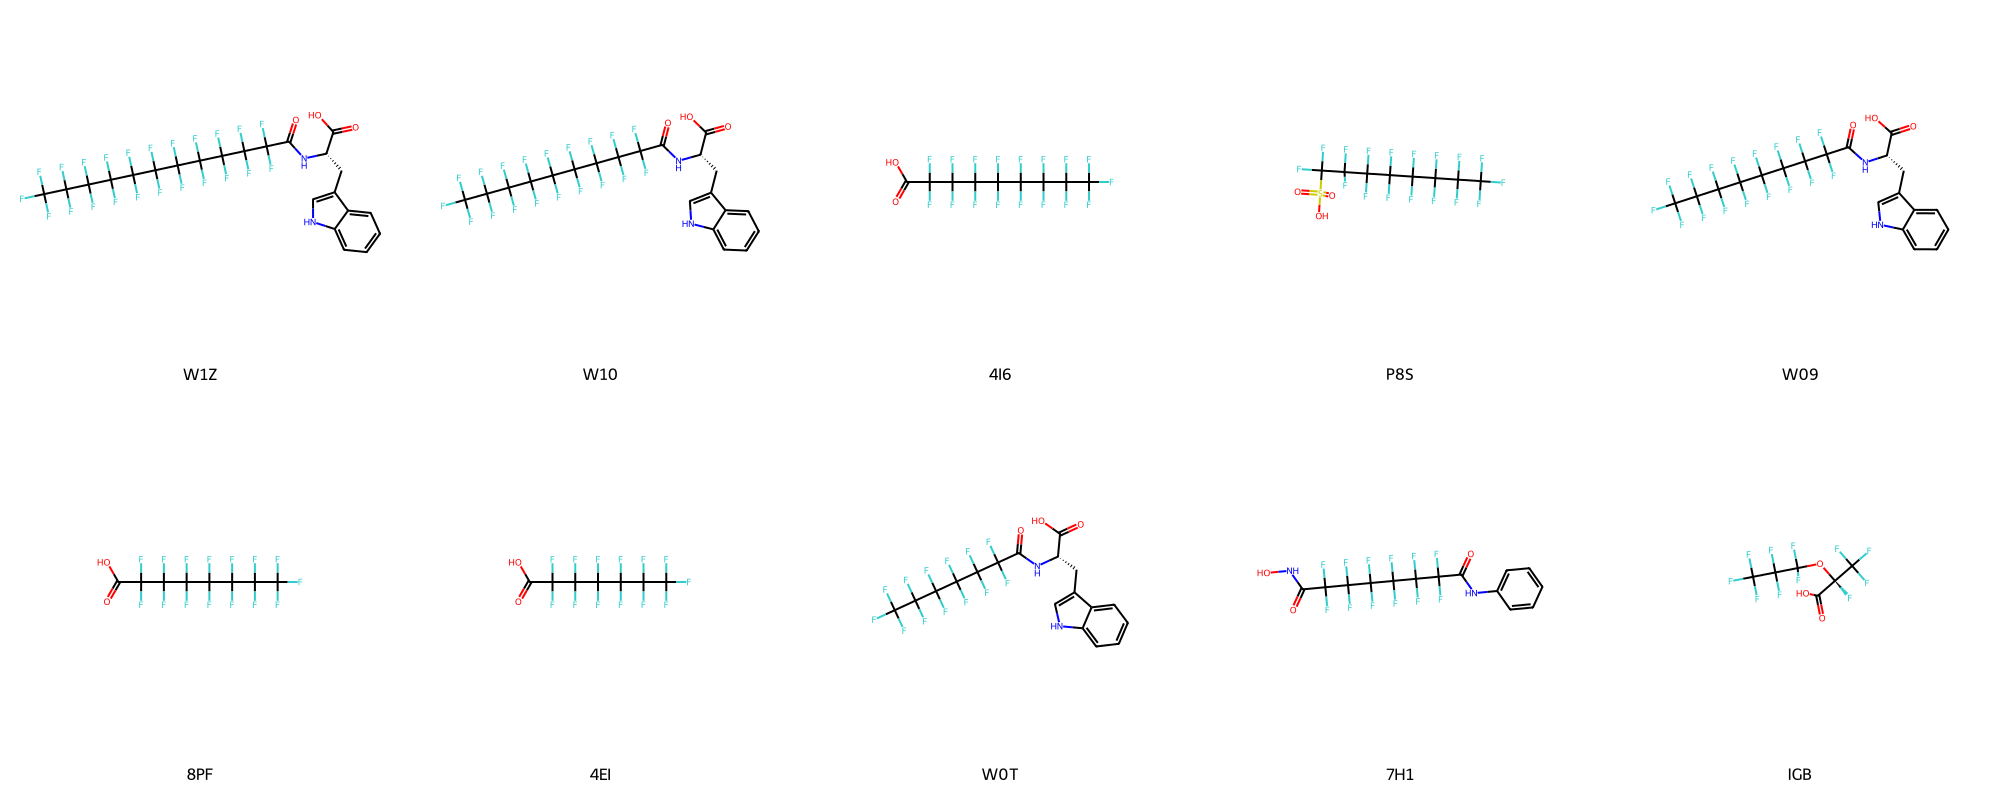

Showing molecules 11 to 20 of 37:


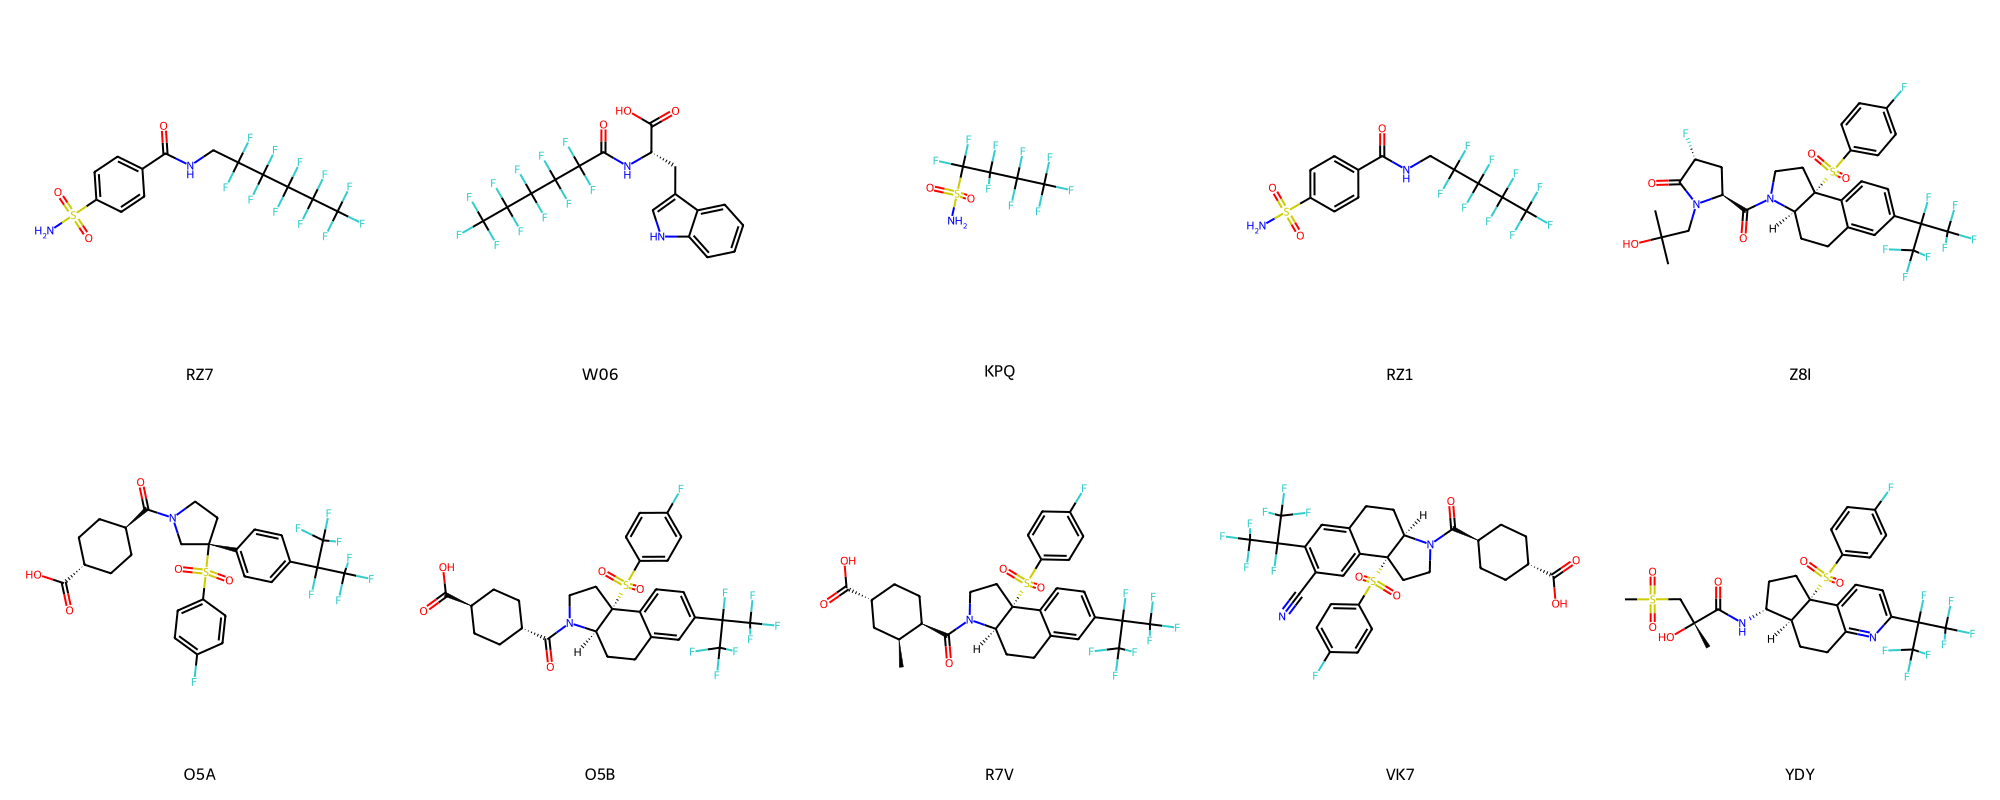

Showing molecules 21 to 30 of 37:


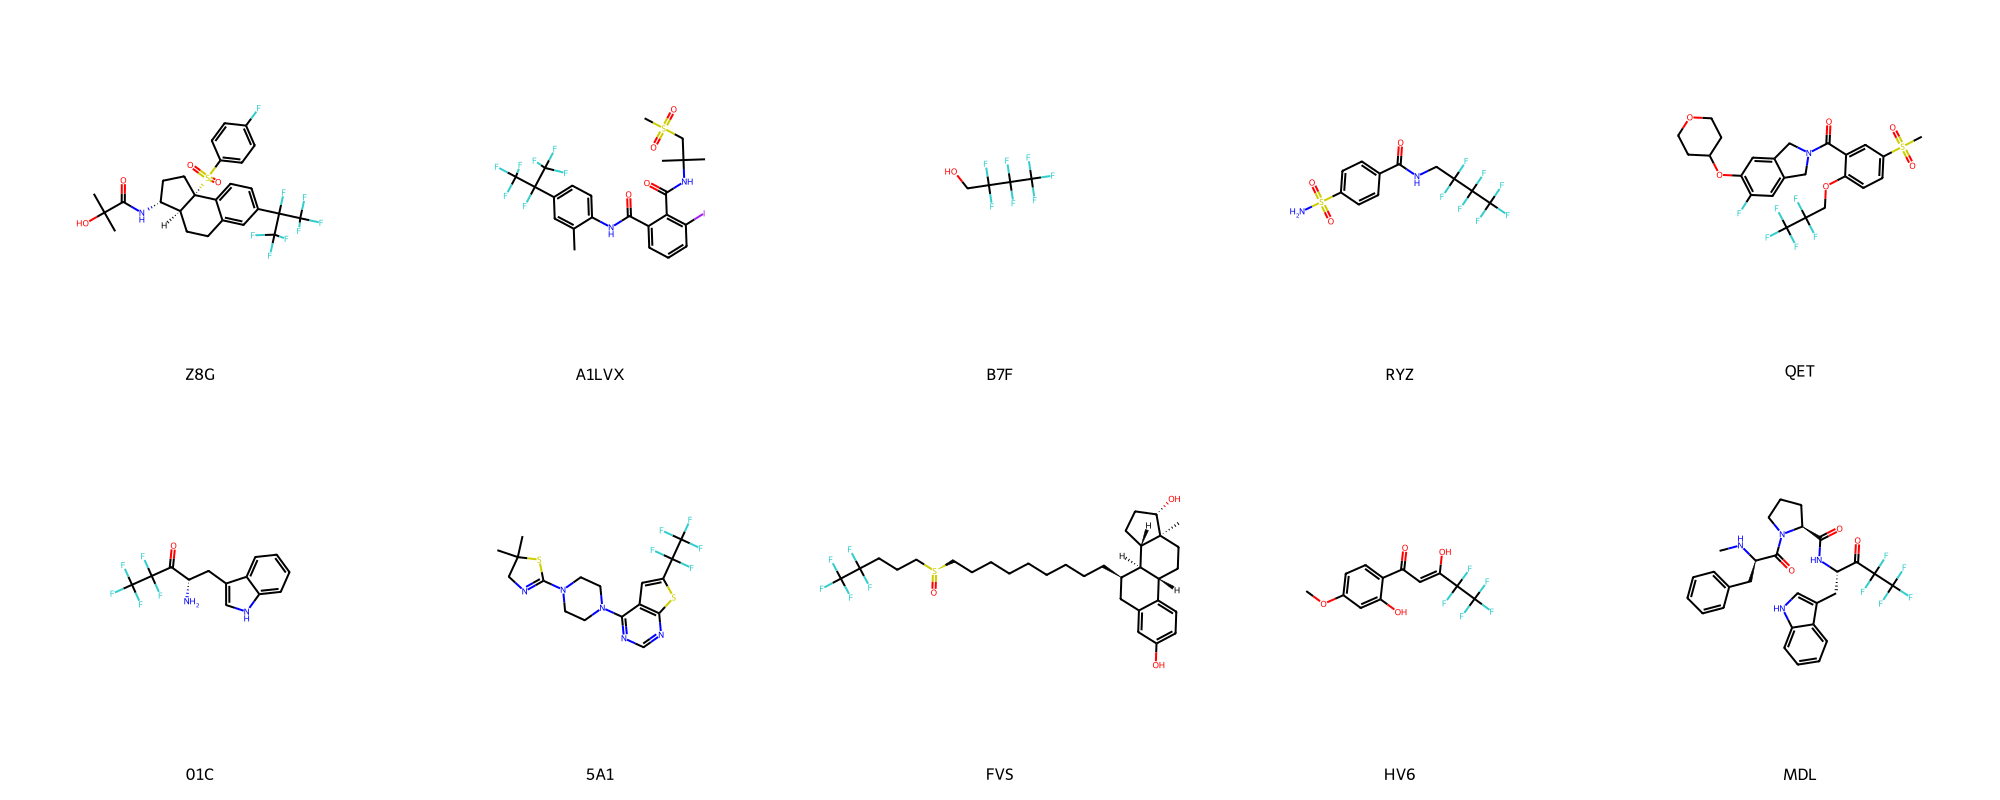

Showing molecules 31 to 37 of 37:


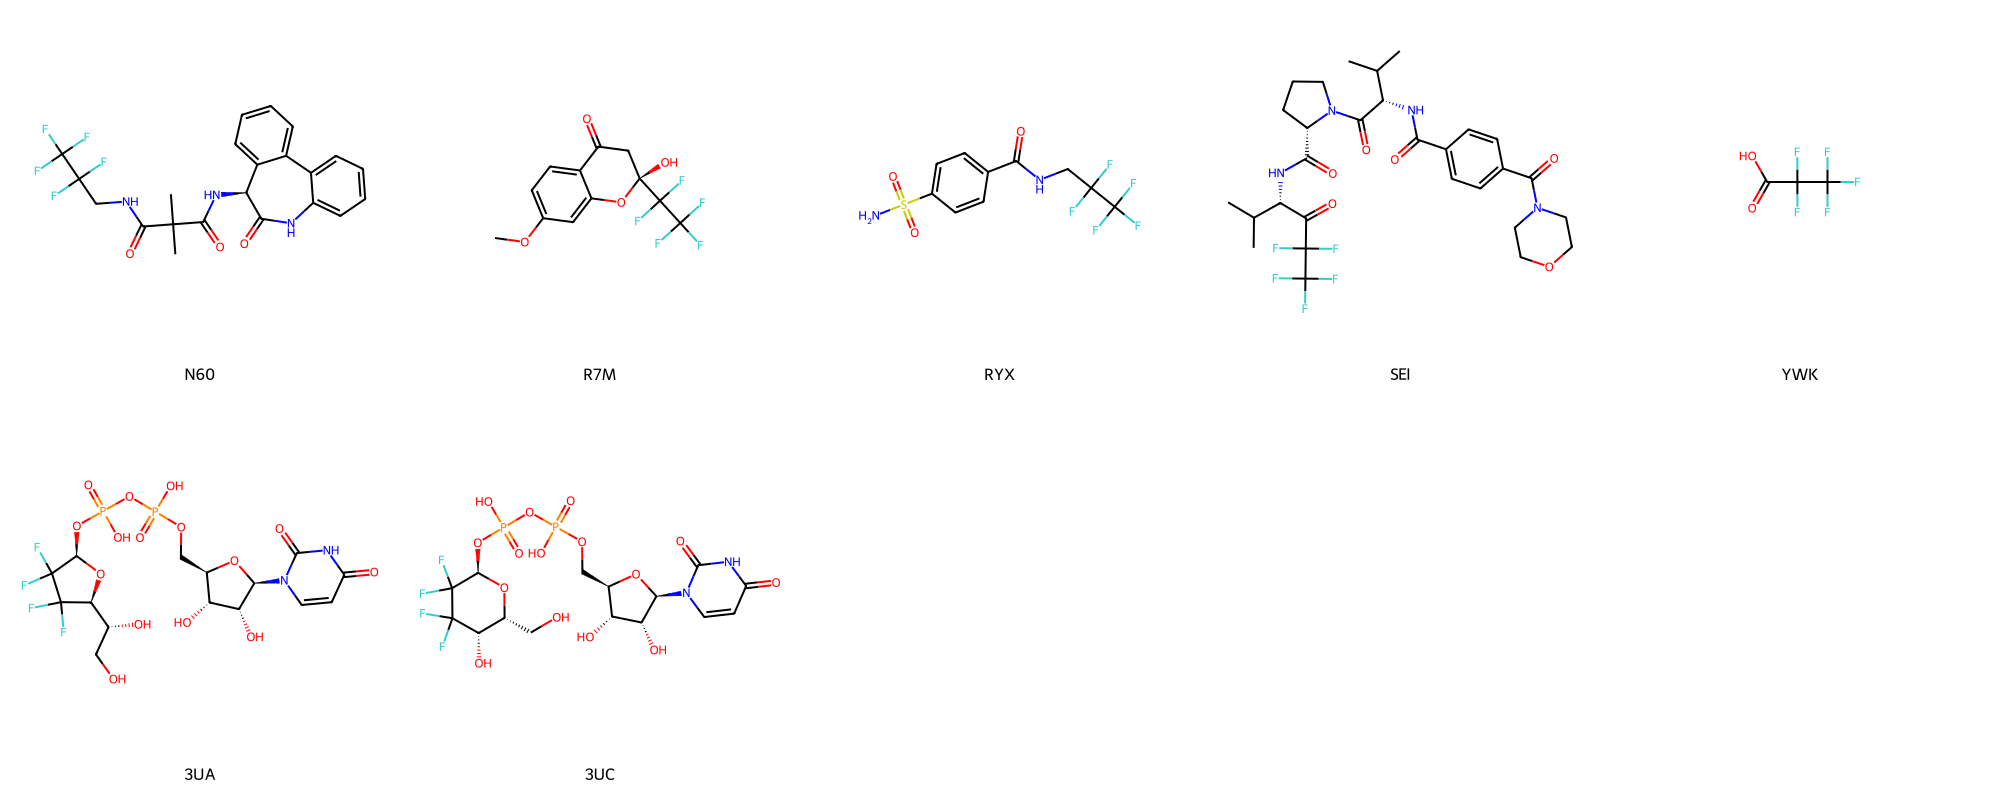

In [5]:
log_file = 'ccdcif_info.log'
# $ head ccdcif_info.log
# # Ligand IDs - Found 6936 ligands with at least 1 fluorine atoms:       # Ligand IDs - Found 6936 ligands with at least 1 fluorine atoms:
# Ligand ID: W1Z ; SMILES: OC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F ; Fluorine Count: 23 ;     Ligand ID: W1Z ; PDBID: 5B2W ;
# Ligand ID: W10 ; SMILES: OC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F ; Fluorine Count: 19 ;   Ligand ID: W10 ; PDBID: 5B2Y ;
# Ligand ID: 4I6 ; SMILES: OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F ; Fluorine Count: 17 ; Ligand ID: 4I6 ; PDBID: 7FEU ;
# Ligand ID: P8S ; SMILES: O[S](=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F ; Fluorine Count: 17 ;   Ligand ID: P8S ; PDBID: 4E99 5JIM ;
# Ligand ID: W09 ; SMILES: OC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F ; Fluorine Count: 17 ; Ligand ID: W09 ; PDBID: 3WSP ;
# Ligand ID: 8PF ; SMILES: OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F ; Fluorine Count: 15 ;        Ligand ID: 8PF ; PDBID: 5JID 6GON 6GOO 7AAI 7FEK 8U57 ;
# Ligand ID: 4EI ; SMILES: OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F ; Fluorine Count: 13 ;       Ligand ID: 4EI ; PDBID: 7FD7 ;
# Ligand ID: W0T ; SMILES: OC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F ; Fluorine Count: 13 ; Ligand ID: W0T ; PDBID: 5B2X ;
# Ligand ID: 7BU ; SMILES: FC(F)(F)C1=C2C=CC3=C(C4=NC(=C(c5ccc(n5[Zn]N23)C(=C6C=CC1=N6)C(F)(F)F)C(F)(F)F)C=C4)C(F)(F)F ; Fluorine Count: 12 ;   Ligand ID: 7BU ; PDBID: 5TGY 7JH6 ;


#ligand_smarts_pattern = 'F' # All ligands (F-containing)
#ligand_smarts_pattern = "FC(F)F" # -CF3 ligands
#ligand_smarts_pattern = 'Oc1cccc(F)c1'  # phenolic fluorine (-Ph-F) ligands
#ligand_smarts_pattern = "[CX4](F)-[CX4](F)-[CX4](F)(F)(F)"  # -(CF2)n-CF3 for n >= 1 ligands
ligand_smarts_pattern = '[CX4]([!#1])(F)(F)-[CX4](F)([!#1])([!#1])' # R-CF2-CF(R')(R") where R, R', R" ≠ H; US EPA OPPT definition
#ligand_smarts_pattern = '[$([#6X4]([!#1;!Cl;!Br;!I])(F)(F)(F)),$([#6X4](F)(F)([!#1;!Cl;!Br;!I])([!#1;!Cl;!Br;!I]))]' # CF3 or CF2 pattern with no H/Cl/Br/I substituents; OECD definition

df = ligand_display(log_file, ligand_smarts_pattern, num_ligands_display=50)

Number of ligands matching the pattern Oc1cccc(F)c1: 7 (Total = 537)
Ligand IDs that match this fully fluorinated pattern:
['B67', '8RH', '8RH', '42Q', 'B5R', 'BXD', 'UKB']
Showing molecules 1 to 7 of 7:


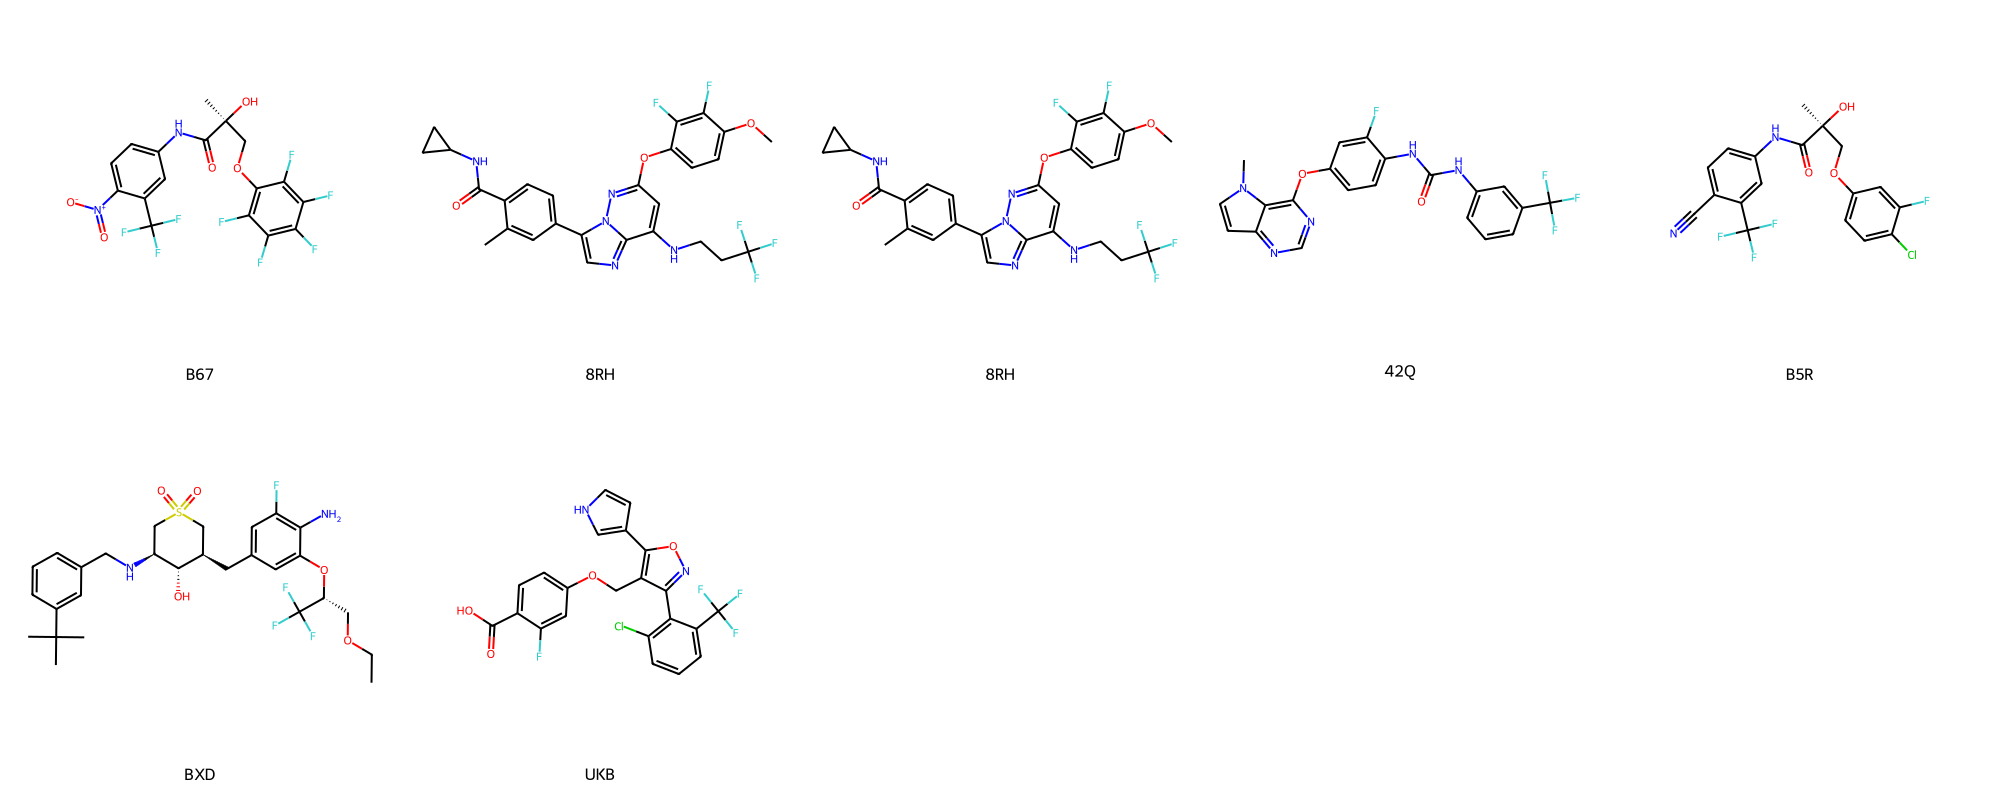

In [54]:
log_file = '/mnt/c/Users/Xipin/Downloads/visual_before.dat'
# ligand_smarts_pattern = '[CX4]([!#1])(F)(F)-[CX4](F)([!#1])([!#1])' # US EPA
ligand_smarts_pattern = 'Oc1cccc(F)c1'  # phenolic fluorine (-Ph-F) ligands
df = ligand_display(log_file, ligand_smarts_pattern, num_ligands_display=200)

Number of ligands matching the pattern Oc1cccc(F)c1: 1 (Total = 201)
Ligand IDs that match this fully fluorinated pattern:
['ZIS']
Showing molecules 1 to 1 of 1:


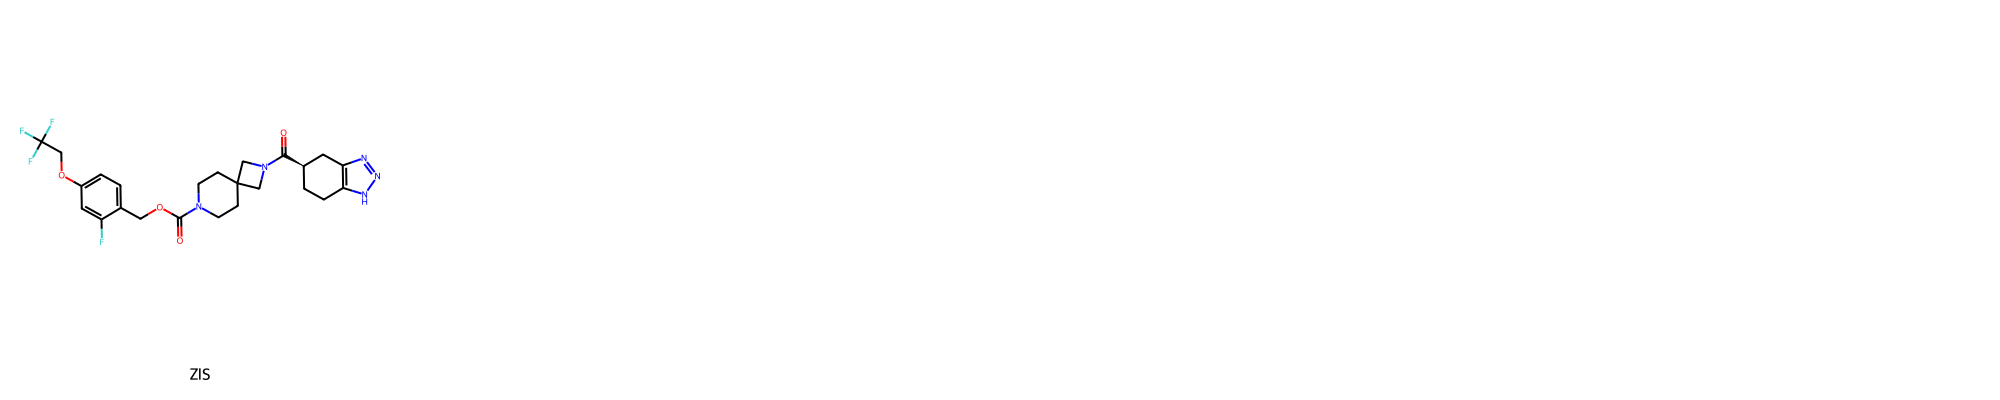

In [55]:
log_file = '/mnt/c/Users/Xipin/Downloads/visual_after.dat'
#Ligand_smarts_pattern = '[CX4]([!#1])(F)(F)-[CX4](F)([!#1])([!#1])' # US EPA
ligand_smarts_pattern = 'Oc1cccc(F)c1'  # phenolic fluorine (-Ph-F) ligands
df = ligand_display(log_file, ligand_smarts_pattern, num_ligands_display=200)

# Questions

## How to get started?

What you need is to follow this notebook. However, if you have some troubles in running these commands. Asking the AI can be a great choice to identify the problem. For example, these scripts in this project were created with the help of AI tools, which will improve your working efficiency.


# Acknowledgement

This project was supported by the University of Georgia (UGA), including the resources from the UGA College of Agricultural & Environmental Sciences and the UGA Georiga Advanced Computing Resource Center (GACRC).